### Imports

In [1]:
from time import time
import matplotlib.pyplot as plt
from functions_watervalues import *

In [2]:
%matplotlib widget

### Declarations

In [3]:
dir_study = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/OneNodeBase_ref"
name_area = "area"

t1 = ThermalUnit(0.1,0,42500.0,"1")
t2 = ThermalUnit(0.2,0,12500.0,"2")
t3 = ThermalUnit(0.3,0,7500.0,"3")

reservoir = Reservoir(0,-5.e4,5.e4,200,dir_study,name_area,"reservoir")

area = Area([t1,t2,t3],[reservoir],dir_study,name_area, "area")
area2 = Area([t1,t2],[],dir_study,name_area, "area2")

NTrain = 10
study = Study([area,area2],2.99,0,3,NTrain, {"area":{"area2":(500,0.001)},"area2":{"area":(500,0.001)}})

In [4]:
xNsteps = 51
X = np.linspace(0, reservoir.capacity, num = xNsteps)

Ncontrols = 51
U = np.linspace(-reservoir.P_pump * H, -reservoir.P_turb * H, Ncontrols)

### Exact calculation with solver

In [5]:
td = time()
V_exact_solver = SDP_exact(study, area, reservoir, False, X)  # Les valeurs de Bellman de la semaine s correspondent aux valeurs pour le début de la semaine s soit la fin de la semaine s-1  
print(time()-td)

190.8417615890503


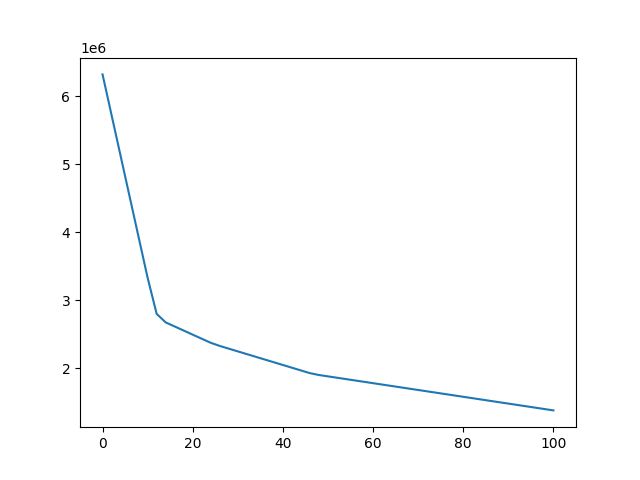

In [16]:
s = 51
plt.figure()
plt.plot(np.linspace(0,100,xNsteps),V_exact_solver[:,s])
plt.show()

### Precalculated rewards

In [7]:
Lu= np.zeros((Ncontrols, S, NTrain))
for u in range(Ncontrols): 
    Lu[u,:,:] =  WeeklyCost(study,area,reservoir,U[u])  

In [8]:
Gu = np.zeros((Ncontrols, S, NTrain))
for u in range(Ncontrols):
    Gu[u, :, :] = Lu[(U>=0).argmax(), :, :] - Lu[u, :, :]

In [9]:
V_tilde = SDP_precalculated_rewards(study,reservoir,False, Gu, X,U)
V_non_tilde = SDP_precalculated_rewards(study, reservoir,True, Gu,X,U)

In [10]:
L_U0 = np.zeros(S+1)

for s in range(S):
    L_U0[s] = np.mean(np.sum(Lu[(U>=0).argmax(), s:52, :], axis=0))

In [11]:
penalties = np.zeros((51, 53))
for s in range(S+1):
    pen = get_penalties(study,reservoir,True,s)
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [20]:
s = 0
i = 1
j = 51
# i = findfirst(STATES.>=Xmin[s-1]);
# j = findlast(STATES.<=Xmax[s-1]);

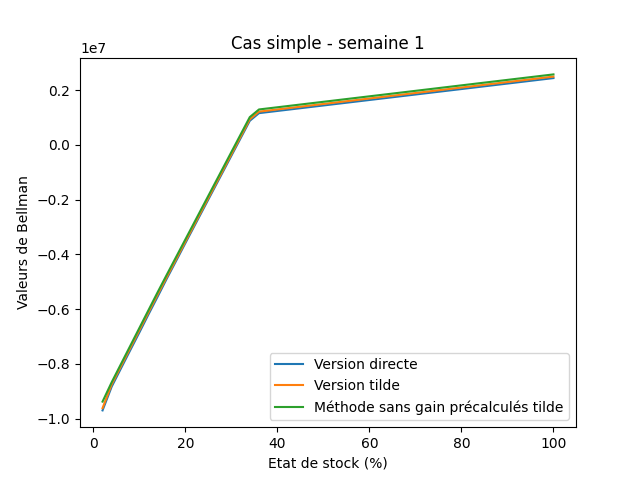

In [21]:
plt.figure()
plt.title(f"Cas simple - semaine {s+1}")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Valeurs de Bellman")
plt.plot(X[i:j]/reservoir.capacity*100, V_non_tilde[i:j, s], label="Version directe")
plt.plot(X[i:j]/reservoir.capacity*100, V_tilde[i:j, s]+penalties[i:j,s], label="Version tilde")
plt.plot(X[i:j]/reservoir.capacity*100, L_U0[s] - V_exact_solver[i:j, s]+penalties[i:j,s], label="Méthode sans gain précalculés tilde")
# plt.plot(X[i:j]/XmaxB*100, penalties[i:j, s], label="Pénalités")
plt.legend()
plt.show()